In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from spacy.lang.en import English
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer

Create n-grams to be used as features

In [2]:
# read in cleaned data
grouped = pd.read_csv("group.csv")

In [ ]:
# rename the column because textsplt is a weird name tbh
grouped = grouped.rename(columns={"textsplt": "text"})

In [3]:
nlp = English(parser=False)
all_features = []

def ngrams(tokens, n):
    # Returns all ngrams of size n in sentence, where an ngram is itself a list of tokens
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

for text in grouped['text']:
    spacy_analysis  = nlp(text)
    spacy_tokens      = [token.orth_ for token in spacy_analysis]
    #normalized_tokens = normalize_tokens(spacy_tokens)

        # Collect unigram tokens as features
        # Exclude unigrams that are stopwords or are punctuation strings (e.g. '.' or ',')
    unigrams = [token for token in spacy_tokens]
        
        # Collect string bigram tokens as features
    bigrams = []
    bigrams = ngrams(spacy_tokens, 2) 
    bigram_tokens = ["_".join(bigram) for bigram in bigrams]
    
    feature_string = " ".join(unigrams + bigram_tokens) 
    
    all_features.append(feature_string)

grouped['ngrams'] = all_features

In [4]:
X_train, X_test, y_train, y_test = train_test_split(grouped['text'], grouped['cNEU'], test_size=0.15, random_state = 1)

In [5]:
grouped[grouped['cNEU']=="n"].count()

Unnamed: 0    1737
sNEU          1737
cNEU          1737
text          1737
ngrams        1737
dtype: int64

In [6]:
print("Number of neurotic labels in data")
grouped[grouped['cNEU']=="y"].count()

Number of neurotic labels in data


Unnamed: 0    1032
sNEU          1032
cNEU          1032
text          1032
ngrams        1032
dtype: int64

In [6]:
stopwords = nlp.Defaults.stop_words
stopwords_list = list(stopwords)

def convert_text_into_features(X, analyzefn="word", range=(1)):
    training_vectorizer = CountVectorizer(
                                          stop_words=stopwords_list,
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

X_features_train, training_vectorizer = convert_text_into_features(X_train, "word", range=(1,2))

lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_features_train, y_train)



/Users/irisyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


LogisticRegression(solver='liblinear')

In [7]:
X_test_features =  training_vectorizer.transform(X_test)

# Classify the test data and see how well you perform
# For various evaluation scores see https://scikit-learn.org/stable/modules/model_evaluation.html
print("Classifying test data")
predicted_labels = lr_classifier.predict(X_test_features)
print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  y_test)))


Classifying test data
Accuracy  = 0.9302884615384616


In [16]:
print('F1  = {}'.format(metrics.f1_score(predicted_labels,  y_test, pos_label='y')))

F1  = 0.9036544850498339


In [15]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_features_train, y_train)

RandomForestClassifier()

In [16]:
print("Classifying rf test data")
rfpredicted_labels = rf.predict(X_test_features)
print('Accuracy  = {}'.format(metrics.accuracy_score(rfpredicted_labels,  y_test)))
print('F1  = {}'.format(metrics.f1_score(rfpredicted_labels,  y_test, pos_label='y')))

Classifying rf test data
Accuracy  = 0.7620192307692307
F1  = 0.5520361990950226


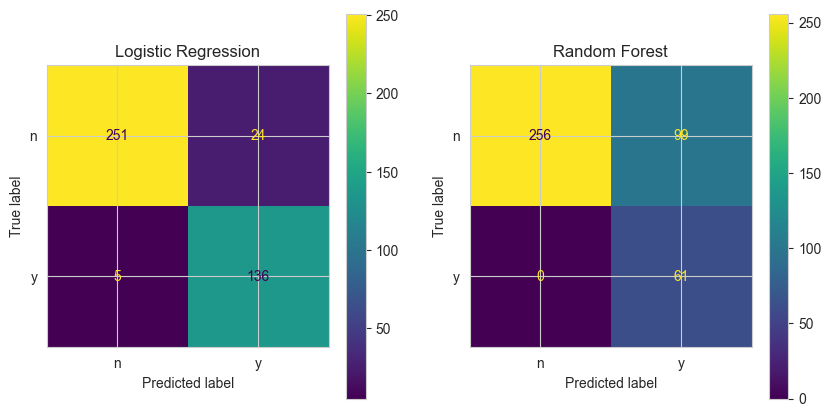

In [40]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.subplot(1, 2, 1)
cm = metrics.confusion_matrix(predicted_labels,  y_test, labels = lr_classifier.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_classifier.classes_)
disp.plot(ax = axes[0])
plt.title('Logistic Regression')


plt.subplot(1, 2, 2)
cmrf = metrics.confusion_matrix(rfpredicted_labels,  y_test, labels = rf.classes_)
disprf = metrics.ConfusionMatrixDisplay(confusion_matrix=cmrf, display_labels=rf.classes_)
disprf.plot(ax = axes[1])
plt.title('Random Forest')

# plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.show()




In [9]:
def most_informative_features(vectorizer, classifier, n=20):
    # Adapted from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers#11116960
    feature_names       = vectorizer.get_feature_names_out()
    coefs_with_features = sorted(zip(classifier.coef_[0], feature_names))
    top                 = zip(coefs_with_features[:n], coefs_with_features[:-(n + 1):-1])
    for (coef_1, feature_1), (coef_2, feature_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, feature_1, coef_2, feature_2))

print("Most informative features")
most_informative_features(training_vectorizer, lr_classifier, 20)



Most informative features
	-0.6178	school         		0.8533	fuck           
	-0.5357	eat            		0.7436	xd             
	-0.5223	working        		0.6089	fucking        
	-0.5094	party          		0.5710	stupid         
	-0.5065	place          		0.5143	car            
	-0.4948	running        		0.5092	kitty          
	-0.4753	feeling        		0.4765	bloody         
	-0.4686	week           		0.4694	hell           
	-0.4676	let            		0.4633	law            
	-0.4663	team           		0.4479	sleep          
	-0.4582	bit            		0.4472	perfect        
	-0.4473	downtown       		0.4448	dance          
	-0.4438	enjoy          		0.4426	haha           
	-0.4367	touch          		0.4310	frog           
	-0.4292	playing        		0.4305	shall          
	-0.4243	soon           		0.4240	iphone         
	-0.4232	tuesday        		0.4234	fair           
	-0.4217	making         		0.4151	cali           
	-0.4205	feet           		0.4124	thinking       
	-0.4093	birthday wishes		0.4098	okay      